In [1]:
%load_ext autoreload
%autoreload 2

import jax.numpy as jnp
from jax import jit, vmap, grad
from jax.lax import scan
from scipy.special import erfcx as sc_erfcx
from scipy.special import wofz as sc_wofz
from jax.scipy.special import erfc
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
plt.style.use('bmh')

from exojax.scipy.special import erfcx, rewofz, imwofz, rewofzx

/home/kawahara/anaconda3/lib/python3.7/site-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [2]:
erfcx(-4.0),sc_erfcx(-4.0)

(DeviceArray(17772222., dtype=float32), 17772220.904016286)

In [3]:
%timeit erfcx(1.0)

262 µs ± 9.16 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [4]:
%timeit sc_erfcx(1.0)

454 ns ± 2.89 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [5]:
N=10000
#xv=jnp.linspace(-10.0,100.0,N)
#xvc=np.linspace(-10.0,100.0,N)
xv=jnp.logspace(-5,5,N)
xvc=np.logspace(-5,5,N)

In [6]:
verfcx=vmap(erfcx)
%timeit verfcx(xv)

374 µs ± 2.97 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [6]:
d=(verfcx(xv) - sc_erfcx(xvc))/ sc_erfcx(xvc)

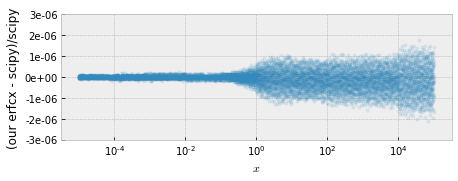

In [7]:
from matplotlib.ticker import FormatStrFormatter

fig=plt.figure(figsize=(7,2.3))
ax=fig.add_subplot(111)
ax.plot(xvc,d,".",alpha=0.1)
ax.yaxis.set_major_formatter(FormatStrFormatter("%1.e"))
plt.ylabel("(our erfcx - scipy)/scipy")
plt.xscale("log")
plt.xlabel("$x$")
plt.ylim(-3.e-6,3.e-6)
plt.savefig("erfcx.pdf", bbox_inches="tight", pad_inches=0.0)

In [4]:
N=100000
xv=jnp.linspace(-10.0,100.0,N)
verfcx=vmap(erfcx)
%timeit verfcx(xv)

366 µs ± 3.53 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [5]:
import matplotlib.pyplot as plt
xv=jnp.linspace(-10.0,10.0,N)

In [6]:
vrewofz=vmap(rewofz,(0,None),0)

In [30]:
# xmax=nend/2

In [9]:
rewofz(502.0,20)

DeviceArray(4.4705546e-05, dtype=float32)

In [7]:
gvvrewofz=vmap(grad(rewofz,argnums=0),(0,None),0)

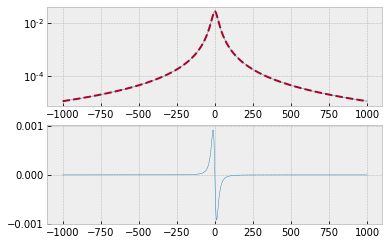

In [8]:

N=1000
xv=jnp.linspace(-1000,1000,N)
xvc=np.linspace(-1000,1000,N)


fig=plt.figure()
ax=fig.add_subplot(211)
ax.plot(xv,vrewofz(xv,20),lw=0.5)
ax.plot(xvc,sc_wofz(xvc+20*(1j)).real,ls="dashed")
plt.yscale("log")
ax=fig.add_subplot(212)
ax.plot(xv,gvvrewofz(xv,20),lw=0.5)


In [14]:
N=10000
xv=jnp.linspace(-10.0,10.0,N)
xvc=np.linspace(-10.0,10.0,N)
%timeit vrewofz(xv,1.0)
%timeit sc_wofz(xvc+1.0*(1j)).real

511 µs ± 172 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
1.15 ms ± 19 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)


In [9]:
N=10000
xv=jnp.linspace(-10.0,10.0,N)
xvc=np.linspace(-10.0,10.0,N)
%timeit gvvrewofz(xv,20)

3.37 ms ± 176 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


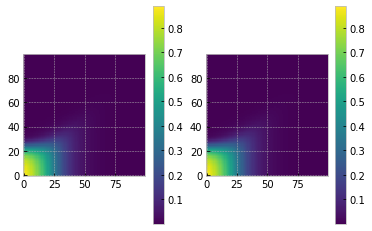

In [15]:
Na=100

xarrv=jnp.logspace(-1,3.3,Na)
xarr=xarrv[:,None]*jnp.ones((Na,Na))

aarrv=jnp.logspace(-1,3.3,Na)
aarr=aarrv[None,:]*jnp.ones((Na,Na))

def H(a,x):
    z=x+(1j)*a
    w = sc_wofz(z)
    return w.real

vrewofz=vmap(rewofz,(0,None),0)
def fvrewofz(a):
    return vrewofz(xarrv,a)
vfvrewofz=vmap(fvrewofz,0,0)

fig=plt.figure()
ax=fig.add_subplot(121)
c=ax.imshow(H(aarr,xarr))
plt.colorbar(c)
plt.gca().invert_yaxis()
ax=fig.add_subplot(122)
c2=ax.imshow(vfvrewofz(aarrv).T)
plt.colorbar(c2)
plt.gca().invert_yaxis()

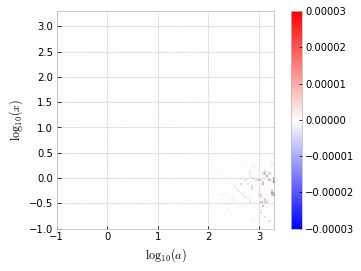

In [16]:
fig=plt.figure()
ax=fig.add_subplot(111)
#c=ax.imshow(np.log10(np.abs(H(aarr,xarr)-Tc(aarr,xarr))/H(aarr,xarr)),cmap="bwr",vmin=-1,vmax=1)
#c=ax.imshow(H(aarr,xarr))
#c=ax.imshow(vfvrewofz(aarrv))
c=ax.imshow((H(aarr,xarr)-vfvrewofz(aarrv).T)/H(aarr,xarr),vmin=-3.e-5,vmax=3.e-5,
            cmap="bwr",extent=([-1,3.3,3.3,-1]))
plt.ylabel("$\log_{10}(x)$")
plt.xlabel("$\log_{10}(a)$")
plt.colorbar(c)
plt.gca().invert_yaxis()

In [17]:
gvvrewofz=vmap(grad(rewofz,argnums=0),(0,None),0)
N=10000
xv=jnp.linspace(-10.0,10.0,N)
%timeit gvvrewofz(xv,20)

3.38 ms ± 194 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


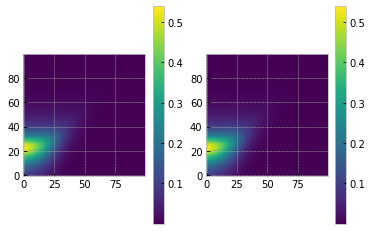

In [18]:
Na=100

xarrv=jnp.logspace(-1,3.3,Na)
xarr=xarrv[:,None]*jnp.ones((Na,Na))

aarrv=jnp.logspace(-1,3.3,Na)
aarr=aarrv[None,:]*jnp.ones((Na,Na))

def iH(a,x):
    z=x+(1j)*a
    w = sc_wofz(z)
    return w.imag

vimwofz=vmap(imwofz,(0,None),0)
def fvimwofz(a):
    return vimwofz(xarrv,a)
vfvimwofz=vmap(fvimwofz,0,0)

fig=plt.figure()
ax=fig.add_subplot(121)
c=ax.imshow(iH(aarr,xarr))
plt.colorbar(c)
plt.gca().invert_yaxis()
ax=fig.add_subplot(122)
c2=ax.imshow(vfvimwofz(aarrv).T)
plt.colorbar(c2)
plt.gca().invert_yaxis()

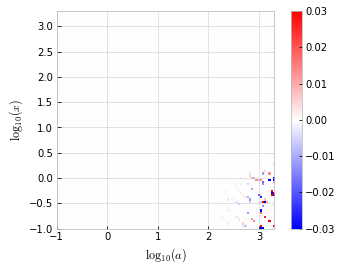

In [19]:
fig=plt.figure()
ax=fig.add_subplot(111)
#c=ax.imshow(np.log10(np.abs(H(aarr,xarr)-Tc(aarr,xarr))/H(aarr,xarr)),cmap="bwr",vmin=-1,vmax=1)
#c=ax.imshow(H(aarr,xarr))
#c=ax.imshow(vfvrewofz(aarrv))
c=ax.imshow((iH(aarr,xarr)-vfvimwofz(aarrv).T)/iH(aarr,xarr),vmin=-3.e-2,vmax=3.e-2,
            cmap="bwr",extent=([-1,3.3,3.3,-1]))
plt.ylabel("$\log_{10}(x)$")
plt.xlabel("$\log_{10}(a)$")
plt.colorbar(c)
plt.gca().invert_yaxis()

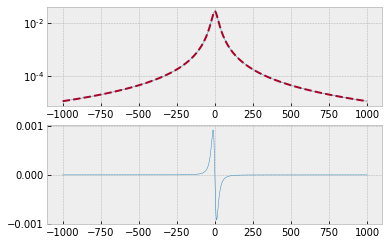

In [10]:
vrewofzx=vmap(jit(rewofzx),(0,None),0)
gvvrewofzx=vmap(grad(jit(rewofzx),argnums=0),(0,None),0)

N=1000
xv=jnp.linspace(-1000,1000,N)
xvc=np.linspace(-1000,1000,N)

fig=plt.figure()
ax=fig.add_subplot(211)
ax.plot(xv,vrewofzx(xv,20),lw=0.5)
ax.plot(xvc,sc_wofz(xvc+20*(1j)).real,ls="dashed")
plt.yscale("log")
ax=fig.add_subplot(212)
ax.plot(xv,gvvrewofzx(xv,20),lw=0.5)

In [11]:
N=100000
xv=jnp.linspace(-10.0,10.0,N)
%timeit gvvrewofzx(xv,20)

1.6 ms ± 236 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)
